# Home Exercise: Kaggle Housing Prices - Data Preparation and Model Training 
## Objective 
Your task is to prepare the Kaggle Housing Prices dataset for machine learning and train a Random Forest model to predict housing prices. This exercise will help you understand how to handle categorical data, deal with missing values, and manage outliers in a real-world dataset. 
## Dataset 
The dataset (train.csv and test.csv) can be downloaded from the Kaggle Housing Prices Competition page. It contains various features related to houses and their sale prices. 

## A. Baseline Model 
### 1. Data Loading and Inspection
- Load the training dataset from train.csv.
- Inspect the data types of each column, focusing on distinguishing between categorical and numerical columns.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
%matplotlib inline
%load_ext autoreload

In [2]:
# Read CSV to Pandas DataFrame and display top 5 rows
train_data = pd.read_csv(
    r'C:\Users\jorda\Documents\studies\DScourse\CourseMaterials\Data\home-data-for-ml-course\train.csv'
    )
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
column_types = train_data.dtypes.to_frame()
column_types.columns = ['type']
column_types.reset_index()
column_types.value_counts()

type   
object     43
int64      35
float64     3
Name: count, dtype: int64

### 2. Handle Missing Values
- Check for missing values in both categorical and numerical columns.
- Impute missing values using appropriate strategies: 
    1. For numerical columns, use the median value. 
    2. For categorical columns, use the most frequent value (mode).

In [4]:
# Stage 2: Handle Missing Values
# Imputing missing values for numerical and categorical data
for col in train_data.columns:
    if train_data[col].isnull().any():
        imputer = SimpleImputer(strategy='median' if train_data[col].dtype in ['int64', 'float64'] else 'most_frequent')
        train_data[[col]] = imputer.fit_transform(train_data[[col]])

train_data.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 81, dtype: int64

### 3. Encode Categorical Variables
- Identify categorical variables in the dataset.
- Apply One-Hot Encoding to these categorical variables to convert them into a format suitable for machine learning models. 

In [5]:
# Stage 1: Encode Categorical Variables
categorical_cols = [col for col in train_data.columns if train_data[col].dtype == 'object']
numerical_cols = [col for col in train_data.columns if train_data[col].dtype in ['int64', 'float64']]

onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_vars = onehot_encoder.fit_transform(train_data[categorical_cols])
encoded_vars_df = pd.DataFrame(encoded_vars, columns=onehot_encoder.get_feature_names_out(categorical_cols))

# Drop original categorical columns and concatenate encoded variables
train_data = train_data.drop(categorical_cols, axis=1)
train_data = pd.concat([train_data, encoded_vars_df], axis=1)

### 4. Deal with Outliers
- Focus on the 'LotArea' feature for outlier analysis.
- Calculate the Interquartile Range (IQR) and identify outliers.
- Remove data points that are significantly higher or lower than the calculated upper and lower bounds.

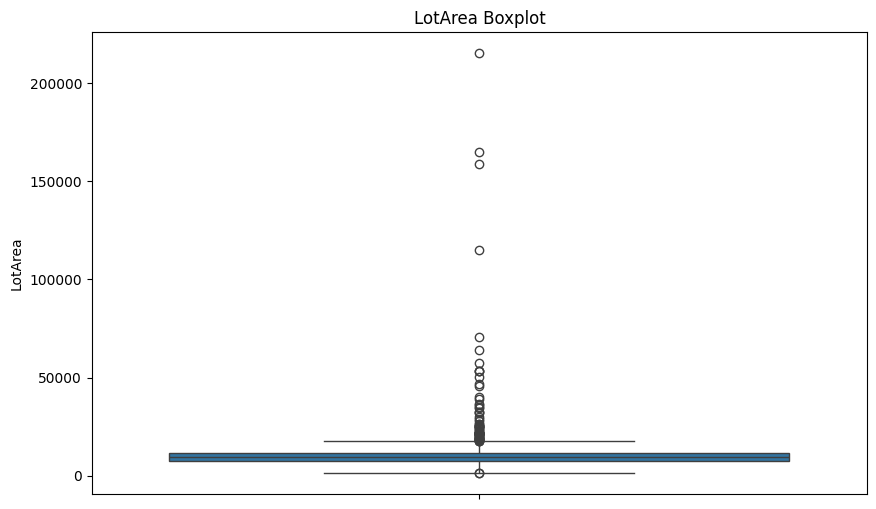

In [6]:
plt.figure(figsize=(10, 6))
plt.title("LotArea Boxplot")
sns.boxplot(data=train_data['LotArea'])
plt.show()

In [7]:
# Stage 3: Deal with Outliers in 'LotArea'
Q1 = train_data['LotArea'].quantile(0.25)
Q3 = train_data['LotArea'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Removing outliers
train_data = train_data[(train_data['LotArea'] >= lower_bound) & (train_data['LotArea'] <= upper_bound)]

### 5. Model Training
- Prepare the dataset for training a Random Forest model by dropping the target variable 'SalePrice' and any identifiers like 'Id'.
- Train a Random Forest Regressor on the cleaned dataset. 

In [8]:
# Preparing data for Random Forest model
X = train_data.drop(['SalePrice', 'Id'], axis=1)
y = train_data['SalePrice']

In [9]:
# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X, y)

RandomForestRegressor(random_state=0)

### 6. Prepare the Test Data and Make Predictions
- Load the test dataset from test.csv.
- Apply the same preprocessing steps to the test data (encoding, imputation, and aligning columns).
- Use the trained Random Forest model to make predictions on the test set. 

In [10]:
# Load the test data
test_data = pd.read_csv(
    r'C:\Users\jorda\Documents\studies\DScourse\CourseMaterials\Data\home-data-for-ml-course\test.csv'
    )

# Keep a copy of the original to use later in Kaggle submission
test_data_original = test_data.copy()

In [11]:
# Stage 2: Handle Missing Values
# Imputing missing values for numerical and categorical data
for col in test_data.columns:
    if test_data[col].isnull().any():
        imputer = SimpleImputer(strategy='median' if test_data[col].dtype in ['int64', 'float64'] else 'most_frequent')
        test_data[[col]] = imputer.fit_transform(test_data[[col]])

train_data.isnull().any().sum()

0

In [12]:
# One Hot Encoding
test_encoded_vars = onehot_encoder.transform(test_data[categorical_cols])
test_encoded_vars_df = pd.DataFrame(test_encoded_vars, columns=onehot_encoder.get_feature_names_out(categorical_cols))

# Drop original categorical columns and concatenate encoded variables
test_data = test_data.drop(categorical_cols, axis=1)
test_data = pd.concat([test_data, test_encoded_vars_df], axis=1)
test_data = test_data.drop('Id', axis=1)

In [13]:
predictions = model.predict(test_data)

### 7. Prepare Submission File
- Create a submission file with predictions, formatted according to Kaggle's submission requirements. 

In [14]:
# # Prepare submission file
# submission = pd.DataFrame({
#     'Id': test_data_original['Id'],
#     'SalePrice': predictions
# })

# # Save submission file
# submission.to_csv('submission_jordan_preprocessing.csv', index=False)

### 8. Submit your file
- Use the submit prediction button to submit the file in the kaggle competition page, what was the score?

Score: 0.14806

## B. K-FoldCross-Validation 
- Objective: Implement k-fold cross-validation to assess the model's performance. 
- Methods: 
    1. Default Scoring: Perform cross-validation using the model's default scoring system.
    2. Neg Mean Squared Error Scoring: Repeat cross-validation using the 'neg_mean_squared_error' scoring metric.

In [15]:
from sklearn.model_selection import cross_val_score

cv_scores_default = cross_val_score(estimator=model, X=X, y=y,cv=5)
print(f"Cross-validation scores: {cv_scores_default}, scores average: {cv_scores_default.mean()}, std: {cv_scores_default.std()}")

Cross-validation scores: [0.89296891 0.91853195 0.88176043 0.89512497 0.85435617], scores average: 0.8885484873361117, std: 0.020866197808622953


In [16]:
cv_scores_neg_mse = cross_val_score(estimator=model, X=X, y=y,cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation scores: {cv_scores_neg_mse}, scores average: {cv_scores_neg_mse.mean()}, std: {cv_scores_neg_mse.std()}")

Cross-validation scores: [-5.54365299e+08 -5.19936502e+08 -6.74242529e+08 -5.41010135e+08
 -9.10477643e+08], scores average: -640006421.6970081, std: 145518551.7397912


## C. Feature Modification
- Objective: Change 'OverallQual' and 'GarageCars' features into categorical variables.

In [17]:
train_data = pd.read_csv(
    r'C:\Users\jorda\Documents\studies\DScourse\CourseMaterials\Data\home-data-for-ml-course\train.csv'
    )

X = train_data.drop(['Id', 'SalePrice'], axis=1)
y = train_data['SalePrice']

# Change 'OverallQual' and 'GarageCars' to str type
X['OverallQual'] = X['OverallQual'].astype('object')
X['GarageCars'] = X['GarageCars'].astype('object')

categorical_cols = [col for col in X.columns if X[col].dtype == 'object']

## D. Average Price Per SqFt
- Calculation: Create a new feature 'average_price_per_sqft' by dividing 'SalePrice' by 'GrLivArea'.

In [18]:
X['average_price_per_sqft'] = y / X['GrLivArea']

average_price_per_sqft = X['average_price_per_sqft'].mean()

## E. Estimated Price Column
- New Feature: Add a column named 'estimated_price', calculated by multiplying 'GrLivArea' with the average ratio obtained in the previous step.

In [19]:
X['estimated_price'] = X['GrLivArea'] * average_price_per_sqft

## F. Feature Importance Analysis
- Objective: Analyze the importance of the new 'estimated_price' feature in the model.

In [20]:
# Get numerical features for pipeline
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

numerical_cols.remove('average_price_per_sqft')

X = X.drop(['average_price_per_sqft'], axis=1)

In [21]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing of categorical data
one_hot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', one_hot)
])

# Full column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ]
)

# Define a Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)

# Full data pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

In [22]:
rf_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  SimpleImputer(strategy='median'),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfB...
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'OverallQual',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir', ...])])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

In [23]:
# Access model from pipeline
model = rf_pipeline.named_steps['model']

# Access preprocessor from pipeline
preprocessor = rf_pipeline.named_steps['preprocessor']

In [24]:
# Extract transformed categorical columns from preprocessor
categorical_cols_transformed = preprocessor.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(categorical_cols)

# Combine transformed categorical columns and numerical columns
new_cols = list(numerical_cols) + list(categorical_cols_transformed)

# Extract transformed data from preprocessor
X_transformed_data = preprocessor.transform(X)

# Reconstitute DataFrame after preprocessing
X_transformed = pd.DataFrame(X_transformed_data, columns=new_cols)

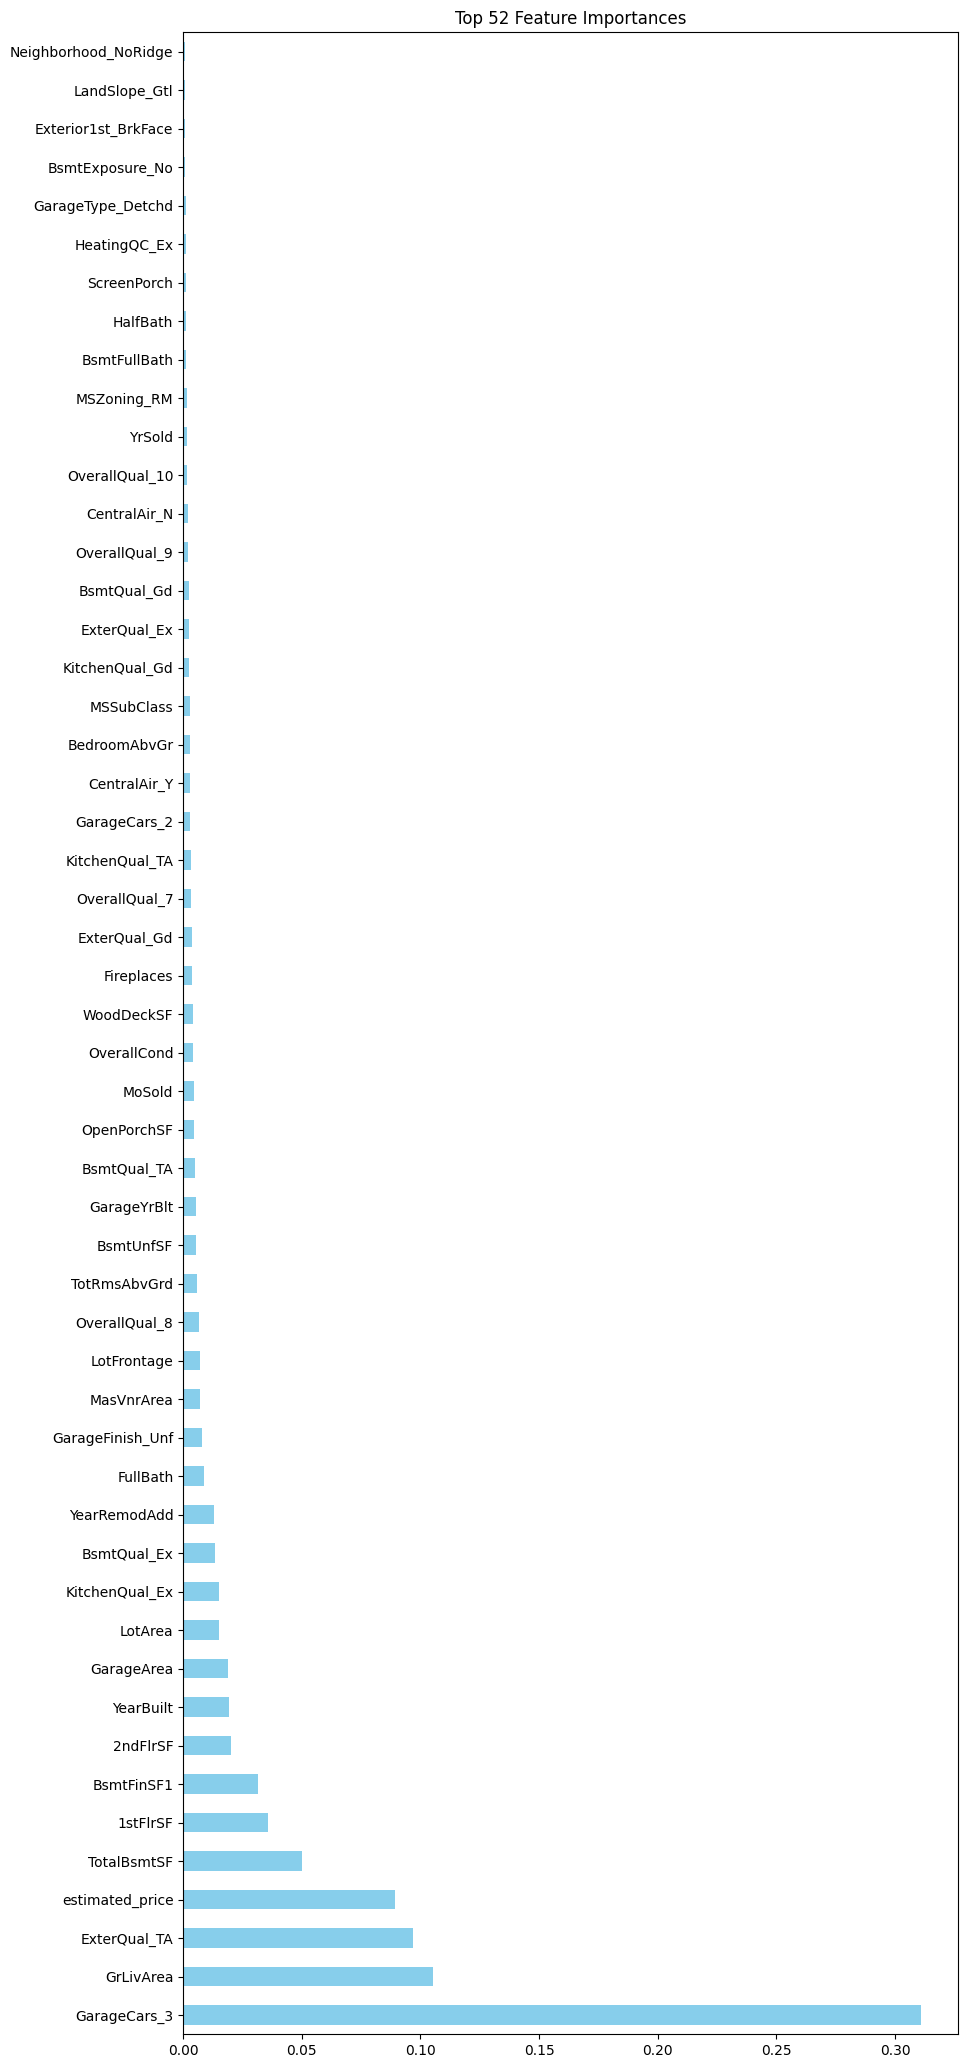

In [25]:
from feature_importance import plot_top_n_importance

plot_top_n_importance(DataFrame=X_transformed, model=model, top_n=52)

# G. Processing and Submission
- Repeat Processing: Apply all preprocessing steps on the test.csv file.
- Kaggle Submission: Submit predictions to Kaggle and record the score.

In [26]:
test_data = pd.read_csv(
    r'C:\Users\jorda\Documents\studies\DScourse\CourseMaterials\Data\home-data-for-ml-course\test.csv'
)

In [27]:
test_data['estimated_price'] = test_data['GrLivArea'] * average_price_per_sqft

In [28]:
# predictions = rf_pipeline.predict(test_data)

# # Prepare submission file
# submission = pd.DataFrame({
#     'Id': test_data_original['Id'],
#     'SalePrice': predictions
# })

# # Save submission file
# submission.to_csv('submission_jordan_exercise_19.csv', index=False)

### Score Reflection
- Kaggle Score: [Include the Kaggle score obtained after submission]

Score: 0.15589

In [29]:
# from ipynb_converter import convert_ipynb_to_pdf

# convert_ipynb_to_pdf(
#     source_file_path=
#     r"C:\Users\jorda\Documents\studies\DScourse\Homework\meeting_19_exercise_jordan.ipynb",
#     output_directory=
#     r"C:\Users\jorda\Documents\studies\DScourse\Homework\PDF",
#     )